# AutoArima model

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
# Load data
df = pd.read_csv("../data/dataset-02.csv")
df = df.set_index(df.time)
df = df.drop(columns="time")
df.head()

,Unnamed: 0,year,month,week,province,city,store,category,department,class,vendor,size,totalQuantity,totalSales,Holiday
time,,,,,,,,,,,,,,,
2012-01-08,0,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size26,1.0,424.971081,True
2012-01-08,1,2012,1,1,province2,city15,store33,category1,department1,class7,vendor2,size29,-1.0,-424.971081,True
2012-01-08,3,2012,1,1,province1,city18,store51,category1,department1,class7,vendor2,size29,1.0,424.971081,True
2012-01-08,4,2012,1,1,province3,city31,store62,category1,department1,class7,vendor2,size29,1.0,424.971081,True
2012-01-08,5,2012,1,1,province3,city31,store40,category1,department1,class7,vendor2,size33,1.0,424.971081,True


In [3]:
# make time series model for store1 and class1 records
data1 = df[(df["store"] == "store1") & (df["class"] == "class1")]

In [4]:
data1 = data1.groupby(data1.index).agg({'totalSales':'sum'})

In [5]:
data1.shape

(313, 1)

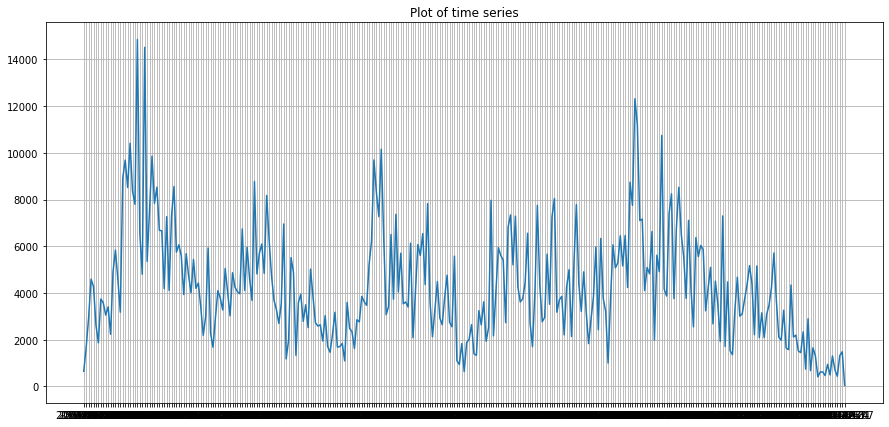

In [6]:
# display data

plt.figure(figsize=(15, 7))
plt.plot(data1.totalSales)
plt.title('Plot of time series')
# plt.xticks(data1.index)
plt.grid(True)
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data1["totalSales"], autolag="AIC")
result

(-4.144025540223257,
 0.0008183718562087821,
 2,
 310,
 {'1%': -3.451621854687657,
  '5%': -2.870908950689806,
  '10%': -2.571761810613944},
 5301.188441446367)

test statistic is -4.1 which is lower than each critical values at different levels(1%, 5% and 10%)
So we can reject the null hypothesis. So series is stationary

ACF

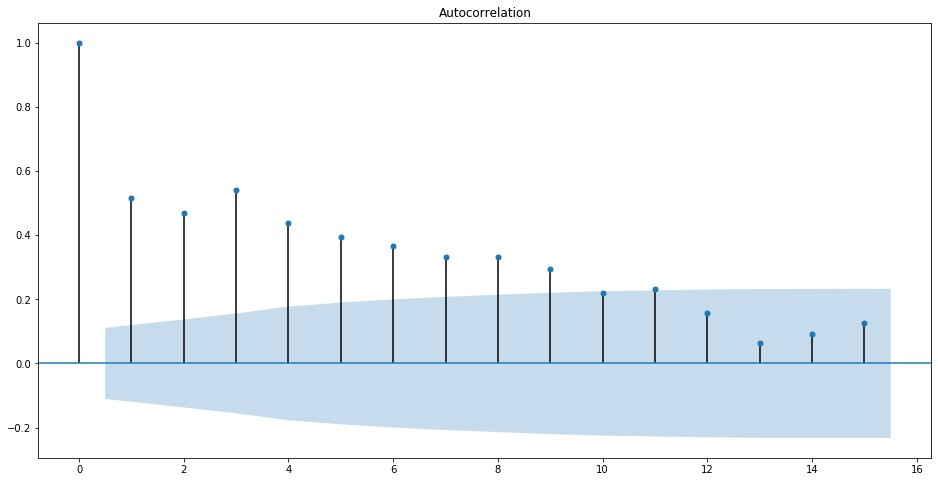

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data1["totalSales"], lags=15)
plt.show()

PACF

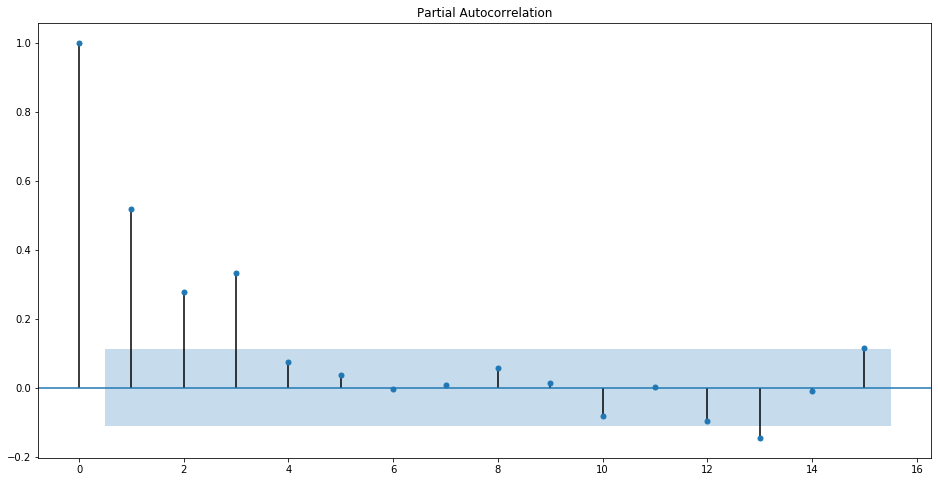

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data1["totalSales"], lags=15)
plt.show()

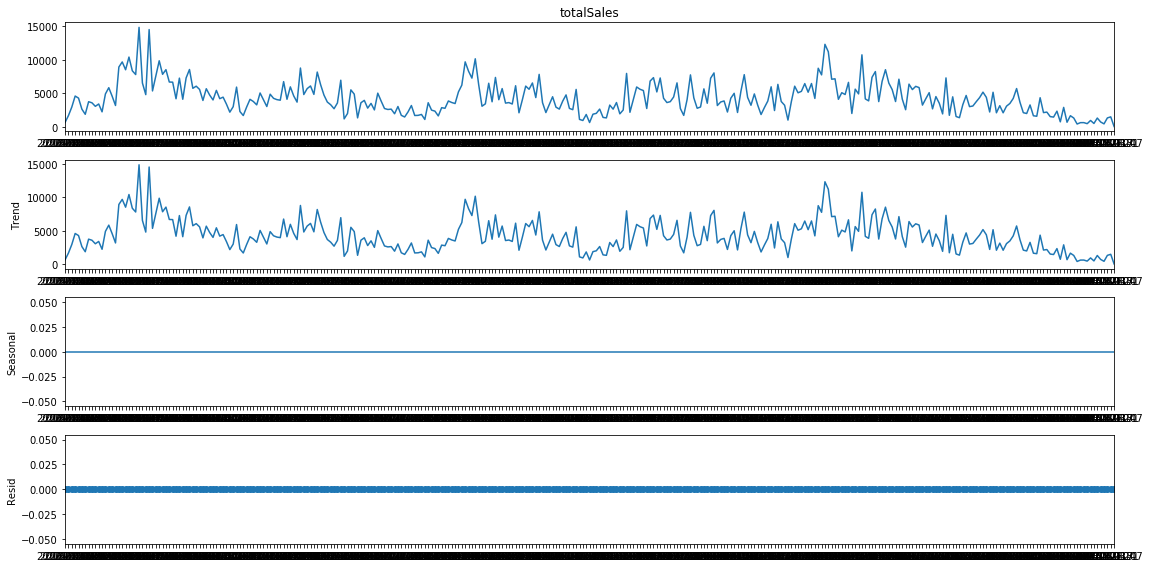

In [10]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

index = pd.DatetimeIndex(data1.index)
df1 = data1.set_index(index)
decom = sm.tsa.seasonal_decompose(data1["totalSales"], period=1)
fig =  decom.plot()


# Make ARIMA model 

In [13]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle

# Load/split your data
y = data1
train, test = train_test_split(y, train_size=250)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m=12,
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)

# Serialize your model just like you would in scikit:
with open('model.pkl', 'wb') as pkl:
    pickle.dump(pipeline, pkl)

# Load it and make predictions seamlessly:
with open('model.pkl', 'rb') as pkl:
    mod = pickle.load(pkl)
    print(mod.predict(15))

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 12) (constant=True); AIC=1600.526, BIC=1628.697, Time=1.091 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=1691.906, BIC=1698.949, Time=0.023 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=1623.714, BIC=1637.800, Time=0.503 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=1644.659, BIC=1658.745, Time=0.188 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=False); AIC=2565.811, BIC=2569.333, Time=0.008 seconds
Fit ARIMA: (2, 0, 2)x(0, 0, 1, 12) (constant=True); AIC=1595.967, BIC=1620.617, Time=1.030 seconds
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 12) (constant=True); AIC=1593.971, BIC=1615.099, Time=0.415 seconds
Fit ARIMA: (2, 0, 2)x(1, 0, 0, 12) (constant=True); AIC=1596.137, BIC=1620.787, Time=0.907 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 12) (constant=True); AIC=1595.407, BIC=1613.014, Time=0.352 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 12) (constant=True); AIC=1595.408,

/Users/digi/anaconda3/envs/testpip/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/digi/anaconda3/envs/testpip/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


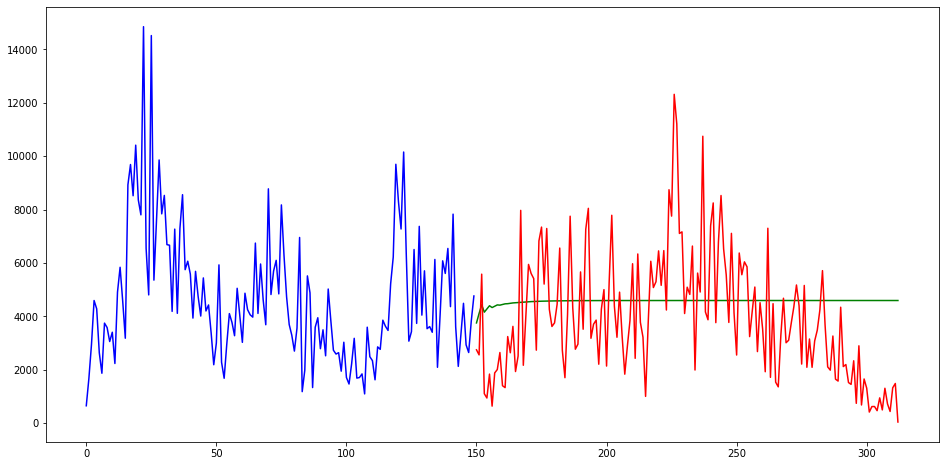

In [14]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = data1
train_size = 150
train, test = train_test_split(y, train_size=train_size)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=4, max_q=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(x[train_size:], forecasts, c='green')
plt.plot(x[train_size:], test, c='red')
plt.show()

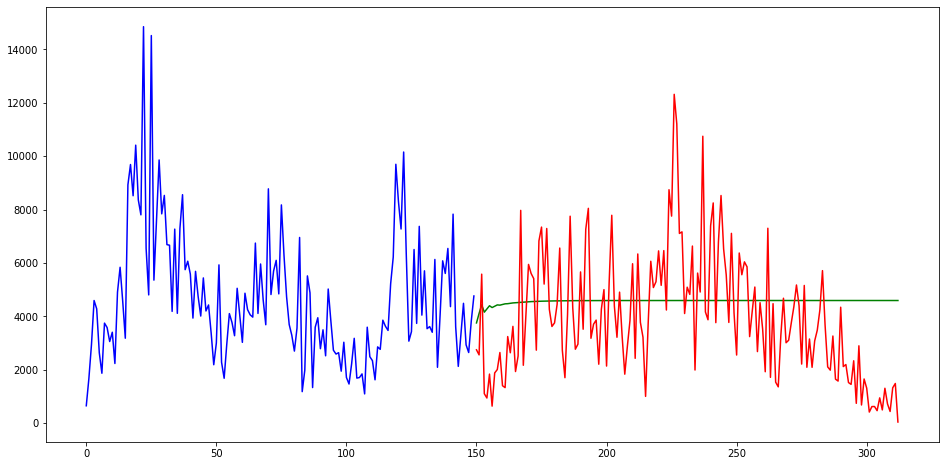

In [15]:
# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(x[train_size:], forecasts, c='green')
plt.plot(x[train_size:], test, c='red')
plt.show()